# Trade-off entre sesgo y varianza

En este notebook vamos a explorar los conceptos de sesgo y varianza en Machine Learning, y el trade-off que existe entre ellos.








## El dilema sesgo vs varianza

Uno de los problemas fundamentales en analítica predictiva es determinar la complejidad óptima del modelo. En este tutorial se discuten los conceptos de aprendizaje y generalización, y como obtener el mejor modelo a partir de los datos.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

### Proceso generador de los datos

El proceso generador de datos es un proceso invisible que produce datos observables en el mundo real. Cuando se construye un modelo de regresión este es el proceso que se desea representar. A continuación se presenta un ejemplo numérico para ilustrar los conceptos.

Existe un proceso generador de datos $f(x)$ que produce la salida $y$ ante la entrada $x$
. Este proceso es desconocido. Para efectos de este ejemplo, este será representado mediante la siguiente función:

In [5]:
#
# Función a aproximar
# (Proceso geneador de datos)
#
def f(x):
    return 2 * np.abs(np.sin(x * np.pi / 4 + 0.75)) / (1 + 0.1 * x)


#
# Datos reales.
# (No disponibles en la realidad)
#
x_real = np.linspace(0, 10, 100)
X_real = x_real[:, np.newaxis]
y_real = f(x_real)

### Muestra de datos

Cuando se construye un modelo de regresión que aproxime el comportamiento de $f(⋅)$, los parámetros son calibrados mediante una muestra de datos, representada por las parejas $(x_i,d_i)$. La salida $d_i$ no es exactamente $f(x_i)$ en la realidad, ya que el valor $y_i$ está contaminado con ruído.

In [6]:
#
# Muestra de datos.
# (Información disponible en la realidad)
#
rng = np.random.default_rng(12345)

x_sample = x_real.copy()
rng.shuffle(x_sample)
x_sample = x_sample[:25]
x_sample = np.sort(x_sample)

y_sample = f(x_sample)
X_sample = x_sample[:, np.newaxis]

### Modelo de regresión

Por facilidad, se usará un polinomio de grado $N$ para realizar la regresión:

$$ y_p = g(x_p) = ϕ_0 + ∑_{n=1}^{N} ϕ_n x^n_p $$
donde el subíndice $p$ representa cada uno de los puntos de la muestra de datos.



###Función de pérdida
En aprendizaje automático, el proceso de aprendizaje consiste en estimar los valores de los parámetros $ϕ_n$, para $n=1,...,N$ que minimizan un error o pérdida. Una selección común es el promedio de errores al cuadrado:

$$ MSE = \frac{1}{P} ∑_{p=1}^{P} (d_p−y_p)^2 = \frac{1}{P} ∑_{p=1}^{P} [d_p−g(x_p)]^2 = \frac{1}{P} ∑_{p=1}^{P} [d_p−(ϕ_0 + ∑_{n=1}^{N} ϕ_n x^n_p)]$$



### Ajuste del modelo a los datos disponibles
El concepto de aprendizaje se refiere a que el modelo realmente capture el comportamiento del proceso generador de los datos (no visible). A continuación, se grafica el proceso subyacente y el comportamiento del polinomio para distintos grados.

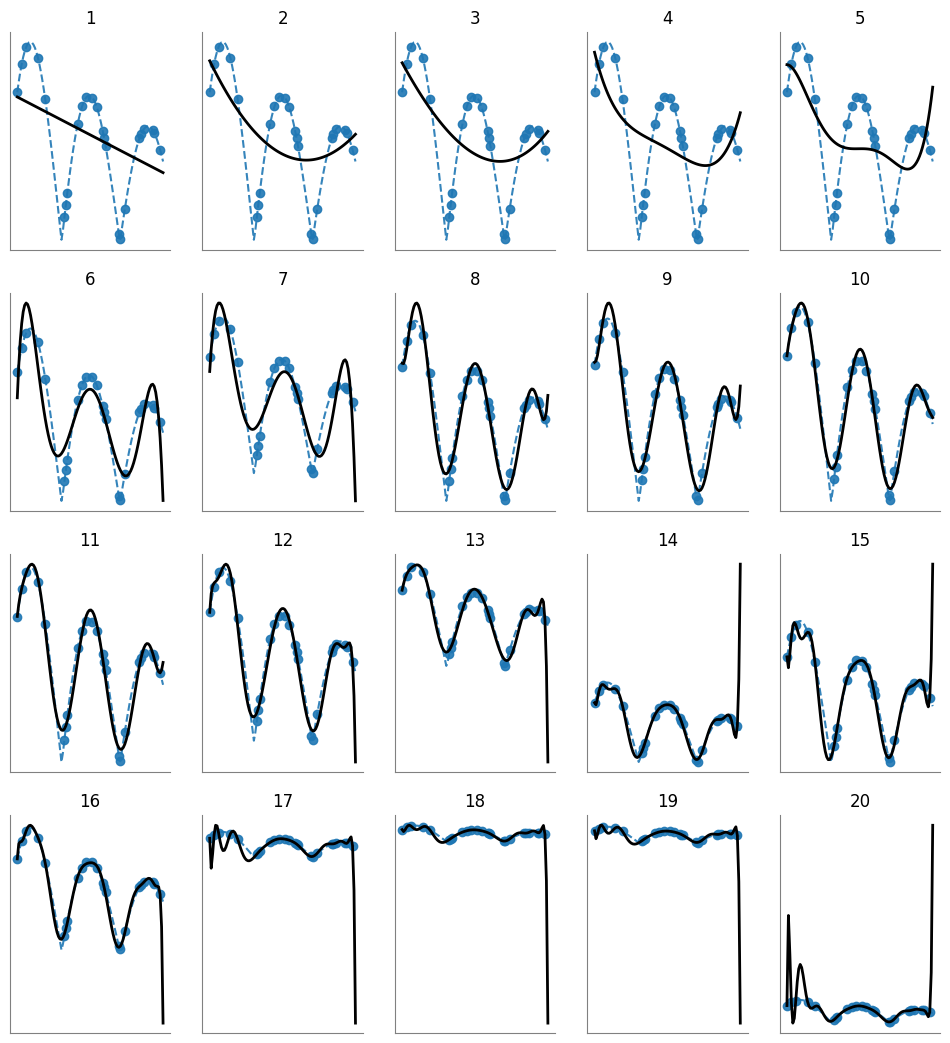

In [7]:
plt.figure(figsize=(12, 13))

degrees = list(range(1, 21))

for i_degree, degree in enumerate(degrees):

    plt.subplot(4, 5, i_degree + 1)

    #
    # Datos
    #
    plt.plot(x_real, y_real, "--", color="tab:blue", alpha=0.9)
    plt.plot(x_sample, y_sample, "o", color="tab:blue", alpha=0.9)

    #
    # Modelo
    #
    model = make_pipeline(
        PolynomialFeatures(degree, include_bias=False),
        MinMaxScaler(),
        LinearRegression(),
    )
    model.fit(X_sample, y_sample)
    y_predicted = model.predict(X_real)

    plt.plot(
        x_real,
        y_predicted,
        color="black",
        linewidth=2,
    )
    plt.title(str(degree))
    plt.xticks([], [])
    plt.yticks([], [])

    plt.gca().spines["left"].set_color("gray")
    plt.gca().spines["bottom"].set_color("gray")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)


plt.show()

En este caso, se puede suponer que el grado del polinomio es una medida de la complejidad del modelo; a mayor grado, mayor complejidad.

De acuedo con la gráfica anterior, se reconocen tres casos:

* **Subajuste:** El modelo no reproduce adecuadamente el comportamiento de los datos usados para estimar sus parámetros, ni del comportamiento subyacente.

* **Sobreajuste:** El modelo empieza a memorizar los datos de entrenamiento; es decir, muy bajo error de ajuste entre puntos, pero oscila locamente entre punto y punto para los puntos de la muestra de entrenamiento.

* **Ajuste óptimo:** El modelo tiene un bajo error de ajuste y el comportamiento de la linea roja es muy similar al comportamiento de la línea negra.



### Dilema sesgo - varianza
El término **sesgo** hace referencia a que tan bien se comporta el modelo para la muestra de datos disponible. En otras palabras, es el error promedio para diferentes muestrad de entrenamiento.

El término **varianza** hace referencia a que tan bien se comporta el modelo para datos nuevos no disponibles hasta ahora (el modelo entra en productivo). En otras palabras, indica que tan sensitivos son los resultados obtenidos al variar el conjunto de entrenamiento.

El dilema sesgo - varianza se refiere que a medida que el modelo aumenta su ajuste a los datos de entrenamiento (disminuye el sesgo), existe un punto a partir del cual aumenta la variabilidad de sus resultados para datos nuevos (aumenta la varianza).

El dilema se presenta al querer disminuir simultáneamente el sesgo y la varianza.

En el gráfico anterior, a medida que aumenta la complejidad (el grado) del modelo, hay un mejor ajuste a los datos conocidos (muestra de entrenamiento), pero el modelo produce una salida muy volatil para puntos por fuera de la muestra (que aumenta con la complejidad del modelo).

###Cómputo de los errores

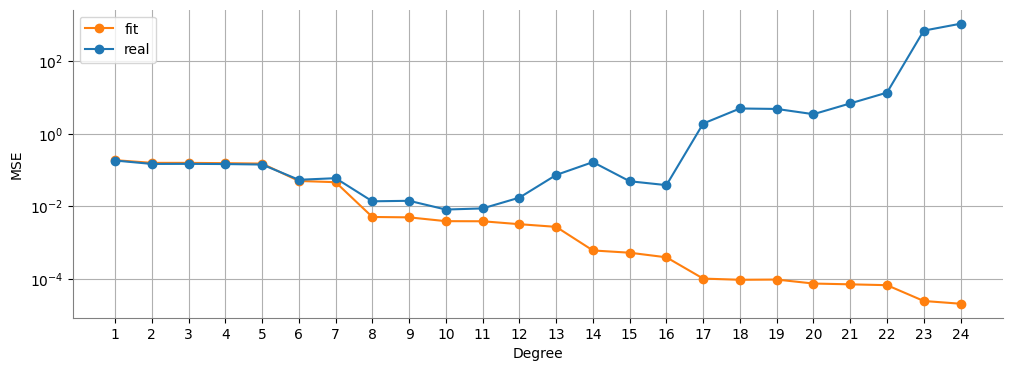

In [8]:
mse_fit = []
mse_real = []
degrees = list(range(1, 25))

for i_degree, degree in enumerate(degrees):

    model = make_pipeline(
        PolynomialFeatures(degree, include_bias=False),
        MinMaxScaler(),
        LinearRegression(),
    )
    model.fit(X_sample, y_sample)
    y_sample_pred = model.predict(X_sample)
    y_pred = model.predict(X_real)

    mse_fit.append(mean_squared_error(y_sample, y_sample_pred))
    mse_real.append(mean_squared_error(y_real.flatten(), y_pred))


plt.figure(figsize=(12, 4))
plt.plot(range(1, len(degrees) + 1), mse_fit, "o-", color="tab:orange", label="fit")
plt.plot(range(1, len(degrees) + 1), mse_real, "o-", color="tab:blue", label="real")

plt.yscale("log")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(degrees)
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

##  1. Manos a la obra

En este notebook vamos a trabajar en un problema de regresión con datos de entrenamiento generados artificialmente. Para ajustar un modelo a esos datos, utilizaremos la regresión lineal. Sin embargo, la relación entre `x` e `y` NO será lineal, por lo que tendremos que hacer un poco de manejo de features para lograrlo. Para entender la idea, veamos el siguiente ejemplo.

$$ y  = 1 - 3x + 5x^2 $$

La relación entre $x$ e $y$ no es lineal, pero si a partir de $x$ creamos un nuevo atributo $x_1 = x^2$, ahora tenemos

$$ y  = 1 - 3x + 5x_1 $$

Entonces, lo que hicimos fue convertir un problema no lineal de una variable en un problema lineal de dos variables. ¿Les suena parecido a algo que hayamos visto?

En general, nosotros no conocemos la relación funcional entre los features ($x$) y la variable que queremos predecir ($y$). Entonces, lo que hacemos es *probar* agregando muchos features nuevos, elevando al cuadrado, al cubo, a la cuarta, etc. Pero llega un momento donde corremos el riesgo de sobreajustar nuestros datos: matemáticamente, si tenemos $n$ datos, podemos ajustar un polinomio de grado $n-1$ a ellos perfectamente. Es decir, la cantidad de features nuevos que creemos y la potencia más alta a la que elevaremos $x$ es un **hiperparámetro**.

En Python, es sencillo hacer este ajuste utilizando la [matriz de Vandermonde](https://es.wikipedia.org/wiki/Matriz_de_Vandermonde). Ésta es una matriz que, dado un vector $x$, tiene en cada columna la potencia de ese vector. Por ejemplo:

In [ ]:
x1 = np.array([1,2,3])
np.vander(x1,N = 4, increasing = True)

array([[ 1,  1,  1,  1],
       [ 1,  2,  4,  8],
       [ 1,  3,  9, 27]])

**Para pensar y probar:** Si `N = 5`, ¿hasta qué potencia eleva al vector?¿Qué ocurre si ponen `increasing = False`?

Notar que la matriz de Vandermonde ya devuelve un arreglo al cual Scikit-Learn puede usar como features.

**Ejercicio:** Prestar atención a las siguientes funciones. ¿Qué hacen? Utilizarlas para implementar el ejemplo de la explicación, con 100 valores de `x` entre -2 y 2. Visualizar.

In [ ]:
def fit_polynomial(x, y, degree):
    model = LinearRegression()
    model.fit(np.vander(x, degree + 1), y)
    return model

def apply_polynomial(model, x):
    degree = model.coef_.size - 1
    y = model.predict(np.vander(x, degree + 1))
    return y

In [ ]:
x = COMPLETAR
y = COMPLETAR

In [ ]:
model = fit_polynomial(COMPLETAR)
p_y = apply_polynomial(COMPLETAR)
print(model.coef_)

[ 5. -3.  0.]


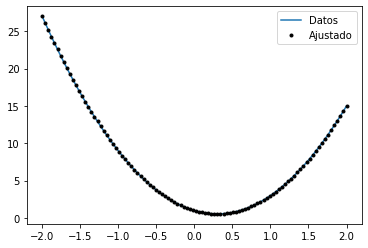

In [ ]:
plt.plot(x, y, label = 'Datos')
plt.plot(x, p_y, 'k.', label = 'Ajustado')
plt.legend()
plt.show()

## 2. Generación de datos de entrenamiento

Ahora, vamos a generar los datos de entrenamiento con los que trabajaremos. Trabajaremos en un problema de regresión, del cual conoceremos la forma funcional entre las variables `x` e `y`:

$$ y  = 2sin(1.5x) $$

**Ejercicio:** escribir una función `sample` que genere muestras **con ruido gaussiano** de esta función. Sus argumentos deben ser `x_min`, `x_max` y `size`, que representan el mínimo y máximo del rango de `x` y la cantidad de muestras a obtener. Luego, graficar las muestras obtenidas y graficar una curva que represente la función **sin ruido**.

In [ ]:
def sample(x_min, x_max, size):
    x = np.linspace(COMPLETAR}
    y = COMPLETAR + np.random.randn(COMPLETAR)
    return (x,y)

In [ ]:
x, y = sample(x_min = 0, x_max = 4.5, size = 50)
f_x = np.linspace(0, 4.5, 50)
f_y = 2 * np.sin(x * 1.5)

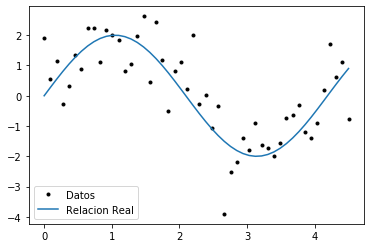

In [ ]:
plt.plot(COMPLETAR,COMPLETAR, 'k.', label = 'Datos')
plt.plot(COMPLETAR, COMPLETAR, label = 'Relacion Real')
plt.legend()
plt.show()

## 3. Sesgo y Varianza

**Ejercicio:** ajustar los datos obtenidos con un polinomio de grado uno (lineal), grado dos (cuadrática) y grado tres (cúbica). Graficar. **Pista:** si lo hacen dentro de un `for`, ¡es muy sencillo!

**Para pensar y probar:** ¿cuál modelo dependerá más de los datos de entrenamiento?¿Y si ajustan un polinomio de grado mayor? Volver a generar datos de entrenamiento y ver qué cambia.

In [ ]:
grados = COMPLETAR

plt.plot(x, f_y,'--', label =  'modelo')
plt.plot(x, y, 'k.', label =  'datos')

for grado in grados:
    model = COMPLETAR
    p_y = COMPLETAR
    plt.plot(COMPLETAR, COMPLETAR, label = grado)

plt.legend()
plt.show()

### Promedio de modelos

Para hacer más evidente la dependencia (o no) de los polinomios de los datos de entrenamiento, generaremos varias muestras de datos, y con cada uno de esos set entrenaremos un modelo de grado a elección. También, graficaremos el modelo promedio obtenido de todos esos modelos.

**Ejercicio:** correr la siguiente celda para diferentes grados (`degree`) del polinomio. ¿Cómo son los modelos obtenidos?¿Cuáles varían más con los datos de entrenamiento?¿Qué ocurre con el modelo promedio?¿Cuándo se parece a la "relación real"?

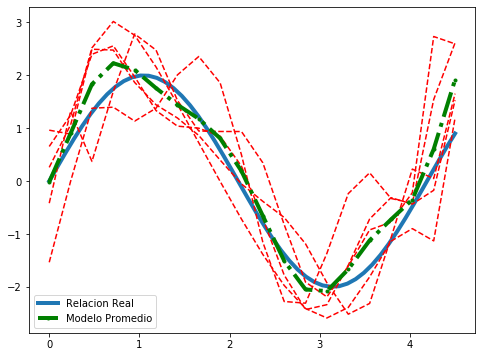

In [ ]:
degree = 10
n_samples = 20
n_models = 5
avg_y = np.zeros(n_samples)

plt.figure(figsize = (8,6))
plt.plot(f_x, f_y, label = 'Relacion Real', lw = 4)
for i in range(n_models):
    (x,y) = sample(x_min = 0, x_max = 4.5, size = n_samples)
    model = fit_polynomial(x, y, degree)
    p_y = apply_polynomial(model, x)
    avg_y = avg_y + p_y
    plt.plot(x, p_y, 'r--')
avg_y = avg_y / n_models
plt.plot(x, avg_y, 'g.-.', label = 'Modelo Promedio', lw = 4)
plt.legend()
plt.show()

### Cálculo de sesgo y varianza

Recordemos que el sesgo es el error de que surge de las suposiciones que tiene nuestro modelo. Cuántos más supuestos, menos flexible será. La varianza, en cambio, es el error que surge de la sensibilidad de nuestro modelo a variaciones en el set de entrenamiento. Cuánto más flexible nuestro modelo, más se ajustará a los datos de entrenamiento. Entonces, el sesgo está asociado a modelos *underfiteados*, mientras que la varianza a modelos *overfiteados*. Por lo tanto, la "variable" que controla si nuestro modelo estará sesgado o sufrirá de mucha varianza es su complejidad. Por eso, decimos que hay un trade-off entre ambos errores.

Notar que, para hablar de sesgo y varianza, consideramos que tenemos muchos modelos. Esto no suele ser así en la aplicación. La pregunta que debemos hacernos es: si entrenara muchas veces este mismo modelo, pero con variaciones en el dataset, ¿cuánto espero que varíe mi modelo? Si varía mucho, probablemente tenga mucha varianza y, por lo tanto, esté overfiteado. Si varía muy poco o directamente no varía, probablemente esté sesgado y underfiteado.

Pero, ¿cómo se calculan ambos errores? Podemos calcular la varianza como cuánto varía en promedio el output de cada modelo entrenado con respecto al promedio de todos los modelos entrenados. Parece un trabalenguas. El sesgo, en cambio, es cuánto se desvía la salida del promedio de los modelos con respecto al verdero output.

Veámoslo en el código. Al igual que en el ejemplo anterior, generamos varias muestras y ajustamos un polinomio a cada una. Calculamos el sesgo y la varianza entre los modelos para diferentes grados polinómicos. El sesgo, la varianza y el error se grafican para diferentes valores de grado.

**Ejercicio:** leer detenidamente las siguientes lineas de código. Prestar atención a qué variable recorre cada `for` y qué se calcula dentro de cada bucle. Comentar el código a medida que comprendan cada paso del mismo.

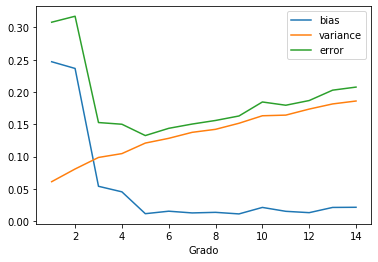

In [ ]:
from numpy.linalg import norm

n_samples = 20

f_x = np.linspace(0, 4.5, n_samples)
f_y = 2 * np.sin(x * 1.5)

n_models = 100
max_degree = 15
var_vals =[]
bias_vals = []
error_vals = []

for degree in range(1, max_degree):
    avg_y = np.zeros(n_samples)
    models = []
    for i in range(n_models):
        (x,y) = sample(0,4.5, n_samples)
        model = fit_polynomial(x, y, degree)
        p_y = apply_polynomial(model, x)
        avg_y = avg_y + p_y
        models.append(p_y)
    avg_y = avg_y / n_models
    bias_2 = np.linalg.norm(avg_y - f_y)/f_y.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += np.linalg.norm(avg_y - p_y)
    variance /= f_y.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)


### Graficamos
plt.plot(range(1, max_degree), bias_vals, label='bias')
plt.plot(range(1, max_degree), var_vals, label='variance')
plt.plot(range(1, max_degree), error_vals, label='error')
plt.xlabel('Grado')
plt.legend()
plt.show()